MCMC Probabilistic Matrix Factorization
=========

Adapted very lightly from: https://stackoverflow.com/questions/29736966/bayesian-probabilistic-matrix-factorization-bpmf-with-pymc3-positivedefinitee

Which is, itself, I believe based on "Bayesian Probabilistic Matrix Factorization using Markov Chain Monte Carlo", Ruslan Salakhutdinov and Andriy Mnih, in _Proceedings of the 25th International Conference on Machine Learning_, Helsinki, Finland, 2008.


In [1]:
import warnings
warnings.filterwarnings('ignore', '.*ix is deprecated.*')

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import scipy as sp
from os import path

DIR = 'test2'
data = pd.read_table(path.join(DIR, 'sample_abundances.tsv'), index_col=0)
strain_abunds = pd.read_table(path.join(DIR, 'strain_abundances.tsv'), index_col=0)
strain_snps = pd.read_table(path.join(DIR, 'strain_genotypes.tsv'), index_col=0)
n, m = data.shape
print(strain_abunds.shape)
print(strain_snps.shape)
print(data.shape)
print(np.abs(data - np.matmul(strain_snps, strain_abunds.T)).mean().mean())


(96, 10)
(1000, 10)
(1000, 96)
1.5452627603422058e-17


In [26]:
n, m = data.shape
dim = 10  # dimensionality
beta_0 = 1  # scaling factor for lambdas; unclear on its use
alpha = np.ones((n,m)) * 2  # fixed precision for likelihood function

print('building the BPMF model')
std = 0.001  # how much noise to use for model initialization
with pm.Model() as bpmf:
    # Specify user feature matrix

    p_u = pm.Normal(
        'mu_u', mu=.1, tau=beta_0, shape=dim,
        testval=np.random.randn(dim) * std + 1/dim)
    U = pm.Bernoulli(
        'U', p=p_u, 
        shape=(n, dim),
        )
    '''   # Specify item feature matrix
    lambda_v = pm.Normal(
        'lambda_v', mu=1/dim, tau=std * np.eye(dim), shape=(dim, dim),
        #testval=100 + np.random.randn(dim, dim) * std
    )
        '''
    mu_v = pm.Normal(
        'mu_v', mu=1/dim, tau=beta_0,# * lambda_v, 
        shape=dim,
    #     testval=np.random.randn(dim) * std
    )
    
    BoundedMvNormal = pm.Bound(pm.MvNormal, lower=0, upper=1)

    V = BoundedMvNormal(
        'V', mu=mu_v, tau=.5*np.eye(dim), shape=(m, dim),
#        testval=np.random.randn(m, dim) * std + 1000
    )

    # Specify rating likelihood function
    R = pm.Normal(
        'R', mu=theano.tensor.dot(U, V.T), tau=alpha,
        observed=data)
    

    start = pm.find_MAP()
    for RV in bpmf.basic_RVs:
        print(RV.name, RV.logp(bpmf.test_point))
    #inference = pm.ADVI()
    #approx = pm.fit(n=30000, method=inference)
    trace = pm.sample(2000, tune=500, cores=10)

building the BPMF model


ValueError: Input dimension mis-match. (input[0].shape[1] = 10, input[1].shape[1] = 96)

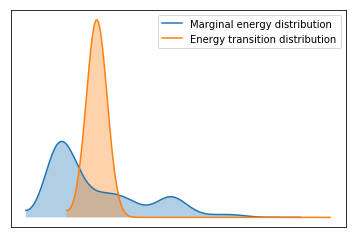

In [10]:
pm.energyplot(trace)

In [13]:
trace.get_values('V')[-2]

array([[-0.03326167, -0.06052525,  0.06608302,  0.06772012, -0.05323647,
         0.15244533,  0.00086113, -0.06287792, -0.01455837,  0.18044662],
       [-0.01475206, -0.0647915 ,  0.03135722,  0.0353581 , -0.0770355 ,
         0.16170427, -0.06609413, -0.04697777, -0.05768652,  0.14223756],
       [-0.06196252, -0.08534257,  0.02060212,  0.04847616, -0.04462879,
         0.14809405, -0.10992787, -0.02862272, -0.0314527 ,  0.16594866],
       [ 0.00726848, -0.06637782, -0.00743127,  0.01164127, -0.06937585,
         0.20634539, -0.11483716, -0.02511204, -0.06855921,  0.14424302],
       [-0.08072432, -0.04298009, -0.01198895,  0.06060826, -0.00526895,
         0.13041733, -0.14436052, -0.01377865, -0.07360239,  0.1884915 ],
       [ 0.01783753, -0.10498522,  0.04891866,  0.02298993, -0.09913827,
         0.14359464, -0.0872222 , -0.01891085, -0.09836422,  0.15706198],
       [-0.0221247 , -0.05356839,  0.02688007,  0.09168358, -0.04821098,
         0.19209405, -0.07113932, -0.07514754

In [27]:
import pystan

ModuleNotFoundError: No module named 'pystan'

In [65]:
import pystan
import numpy as np

ocode = """
data {
    int<lower=1> n;   // number of SNPs
    int<lower=1> m;   // number of samples
    int<lower=1> d;   // number of strains
    matrix<lower=0,upper=1>[n,m] R;
}
parameters {
    matrix<lower=0,upper=1>[n,d] V;
    matrix<lower=0,upper=1>[d,m] U;
    real<lower=0,upper=0.1> alpha_v[n];
    real<lower=0,upper=0.1> beta_v[n];
    matrix[d,d] lambda_u;
    vector[d] mu_u;
}
model {
    for (i in 1:n){
        alpha_v[i] ~ uniform(0, 0.1);
        beta_v[i] ~ uniform(0, 0.1);
        V[i] ~ beta(alpha_v[i], beta_v[i]);
    }
    lambda_u ~ wishart(1.0/d, diag_matrix(rep_vector(1, d)));
    mu_u ~ normal(1.0,diagonal(lambda_u));
    for (i in 1:d){
        row_vector[m] tempvec;
        tempvec ~ multi_normal(mu_u, lambda_u);
        //U[i] = v;
        }
    R ~ normal(V*U, 1);
}
"""
sm = pystan.StanModel(model_code=ocode)

op = sm.optimizing(data=dict(n=n, m=m, d=10, R=data))

op

ValueError: Failed to parse Stan model 'anon_model_8e392cf955d1e175ee9b58e842f601b6'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

No matches for: 

  matrix ~ normal(matrix, int)

Available argument signatures for normal:

  real ~ normal(real, real)
  real ~ normal(real, real[])
  real ~ normal(real, vector)
  real ~ normal(real, row vector)
  real ~ normal(real[], real)
  real ~ normal(real[], real[])
  real ~ normal(real[], vector)
  real ~ normal(real[], row vector)
  real ~ normal(vector, real)
  real ~ normal(vector, real[])
  real ~ normal(vector, vector)
  real ~ normal(vector, row vector)
  real ~ normal(row vector, real)
  real ~ normal(row vector, real[])
  real ~ normal(row vector, vector)
  real ~ normal(row vector, row vector)
  real[] ~ normal(real, real)
  real[] ~ normal(real, real[])
  real[] ~ normal(real, vector)
  real[] ~ normal(real, row vector)
  real[] ~ normal(real[], real)
  real[] ~ normal(real[], real[])
  real[] ~ normal(real[], vector)
  real[] ~ normal(real[], row vector)
  real[] ~ normal(vector, real)
  real[] ~ normal(vector, real[])
  real[] ~ normal(vector, vector)
  real[] ~ normal(vector, row vector)
  real[] ~ normal(row vector, real)
  real[] ~ normal(row vector, real[])
  real[] ~ normal(row vector, vector)
  real[] ~ normal(row vector, row vector)
  vector ~ normal(real, real)
  vector ~ normal(real, real[])
  vector ~ normal(real, vector)
  vector ~ normal(real, row vector)
  vector ~ normal(real[], real)
  vector ~ normal(real[], real[])
  vector ~ normal(real[], vector)
  vector ~ normal(real[], row vector)
  vector ~ normal(vector, real)
  vector ~ normal(vector, real[])
  vector ~ normal(vector, vector)
  vector ~ normal(vector, row vector)
  vector ~ normal(row vector, real)
  vector ~ normal(row vector, real[])
  vector ~ normal(row vector, vector)
  vector ~ normal(row vector, row vector)
  row vector ~ normal(real, real)
  row vector ~ normal(real, real[])
  row vector ~ normal(real, vector)
  row vector ~ normal(real, row vector)
  row vector ~ normal(real[], real)
  row vector ~ normal(real[], real[])
  row vector ~ normal(real[], vector)
  row vector ~ normal(real[], row vector)
  row vector ~ normal(vector, real)
  row vector ~ normal(vector, real[])
  row vector ~ normal(vector, vector)
  row vector ~ normal(vector, row vector)
  row vector ~ normal(row vector, real)
  row vector ~ normal(row vector, real[])
  row vector ~ normal(row vector, vector)
  row vector ~ normal(row vector, row vector)

require real scalar return type for probability function.
  error in 'unknown file name' at line 29, column 24
  -------------------------------------------------
    27:         //U[i] = v;
    28:         }
    29:     R ~ normal(V*U, 1);
                               ^
    30: }
  -------------------------------------------------



In [34]:
print(np.mean(y2))


0.219999028126


OrderedDict([('mu', array(0.21999902812623962))])

In [3]:
test_size = m // 10
train_size = m - test_size

print(n, m, test_size, train_size)
train = data.copy()
train.ix[:,train_size:] = np.nan  # remove test set data
train[train.isnull()] = train.mean().mean()  # mean value imputation
train = train.values

test = data.copy()
test.ix[:,:train_size] = np.nan  # remove train set data
test = test.values    

# Low precision reflects uncertainty; prevents overfitting
alpha_u = alpha_v = 1/np.var(train)
alpha = np.ones((n,m)) * 2  # fixed precision for likelihood function
dim = 63  # dimensionality

# Specify the model.
with pm.Model() as pmf:
    pmf_U = pm.MvNormal('U', mu=0, tau=alpha_u * np.eye(dim),
                        shape=(n, dim), testval=np.random.randn(n, dim)*.01)
    pmf_V = pm.MvNormal('V', mu=0, tau=alpha_v * np.eye(dim),
                        shape=(m, dim), testval=np.random.randn(m, dim)*.01)
    pmf_R = pm.Normal('R', mu=theano.tensor.dot(pmf_U, pmf_V.T),
                      tau=alpha, observed=train)

    # Find mode of posterior using optimization
    start = pm.find_MAP(method='powell')

10000 96 9 87


/opt/sys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/opt/sys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
  0%|          | 0/5000 [00:00<?, ?it/s]/opt/sys/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:502: RuntimeWarning: Method powell does not use

MemoryError: 

In [ ]:
pm.traceplot(trace)

KeyboardInterrupt: 

In [11]:
bpmf.vars

[mu_u, U, lambda_v, mu_v, V]

In [ ]:
n, m = data.shape
dim = 10  # dimensionality
beta_0 = 1  # scaling factor for lambdas; unclear on its use
alpha = np.ones((n,m)) * 2  # fixed precision for likelihood function

print('building the BPMF model')
std = .05  # how much noise to use for model initialization
with pm.Model() as bpmf:
    # Specify user feature matrix
    lambda_u = pm.Wishart(
        'lambda_u', nu=dim, V=np.eye(dim), shape=(dim, dim),
        testval=np.random.randn(dim, dim) * std)
    mu_u = pm.Normal(
        'mu_u', mu=0, tau=beta_0 * lambda_u, shape=dim,
        testval=np.random.randn(dim) * std)
    U = pm.MvNormal(
        'U', mu=mu_u, tau=lambda_u, shape=(n, dim),
        testval=np.random.randn(n, dim) * std)

    # Specify item feature matrix
    lambda_v = pm.Wishart(
        'lambda_v', nu=dim, V=np.eye(dim), shape=(dim, dim),
        testval=np.random.randn(dim, dim) * std)
    mu_v = pm.Normal(
        'mu_v', mu=0, tau=beta_0 * lambda_v, shape=dim,
         testval=np.random.randn(dim) * std)
    V = pm.MvNormal(
        'V', mu=mu_v, tau=lambda_v, shape=(m, dim),
        testval=np.random.randn(m, dim) * std)

    # Specify rating likelihood function
    R = pm.Normal(
        'R', mu=theano.tensor.dot(U, V.T), tau=alpha,
        observed=train)

# `start` is the start dictionary obtained from running find_MAP for PMF.
for key in bpmf.test_point:
    if key not in start:
        start[key] = bpmf.test_point[key]

with bpmf:
    step = pm.NUTS(scaling=start)

In [ ]:
pm.LKJCorr?